# **课程作业**

**利用GEE平台，分析维多利亚湖某一区域的植被指数在2013-2020年变化，考虑其趋势和在干旱年份如2017年的情况**

In [2]:
#在Colab平台中导入GEEmap
import subprocess

try:
    import geemap
except ImportError:
    print('Installing geemap ...')
    subprocess.check_call(["python", '-m', 'pip', 'install', 'geemap'])

Installing geemap ...


In [3]:
import ee
import geemap

ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=AIO6CAVATNxAeiJ_8_kbfdDUEBo6xjiOPz0D0YxAJkU&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWg1eoXN5Dja87yIjiaIg4N97Z_ifZfR3gHsRuH4065FmGheQ7qlcDM

Successfully saved authorization token.


In [4]:
#设定研究区域ROI
roi = ee.Geometry.Polygon(
        [[[34.5,-1.5],[34.6,-1.5],[34.6,-1.6],[34.5,-1.6],[34.5,-1.5]]])
roi_map = geemap.Map()
roi_map.add_basemap('HYBRID')
roi_map.centerObject(roi, 9)
roi_map.addLayer(roi,{},"roi")
roi_map.addLayerControl() # This line is not needed for ipyleaflet-based Map.
roi_map

Map(center=[-1.550000196346228, 34.55000000000001], controls=(WidgetControl(options=['position', 'transparent_…

选择合适时间段的影像数据，并进行去云操作

In [5]:
startDate = ee.Date("2013-1-1");
endDate  =ee.Date("2020-12-31");
images = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(roi) \
    .filterDate(startDate, endDate) \
    .filter(ee.Filter.lte("CLOUD_COVER", 10))

In [6]:
def cloud_mask(image):
  cloudShadowBitMask = 1 << 3
  cloudsBitMask = 1 << 5
  snowBitMask = 1 << 4
  qa = image.select('pixel_qa')
  mask1 = qa.bitwiseAnd(cloudShadowBitMask).eq(0)
  mask2 = qa.bitwiseAnd(cloudsBitMask).eq(0)
  mask3 = qa.bitwiseAnd(snowBitMask).eq(0)
  mask = mask1.add(mask2).add(mask3)
  return image.updateMask(mask.gte(1))
images = images.map(cloud_mask)

查看影像属性以及研究区域时间段内的景数

In [6]:
print(images.getInfo())

{'type': 'ImageCollection', 'bands': [], 'id': 'LANDSAT/LC08/C01/T1_SR', 'version': 1639397895472414, 'properties': {'system:visualization_0_min': '0.0', 'type_name': 'ImageCollection', 'keywords': ['cfmask', 'cloud', 'fmask', 'global', 'l8sr', 'landsat', 'lc08', 'reflectance', 'sr', 'usgs'], 'visualization_1_bands': 'B5,B4,B3', 'thumb': 'https://mw1.google.com/ges/dd/images/LANDSAT_SR_thumb.png', 'visualization_1_max': '30000.0', 'description': '<p>This dataset is the atmospherically corrected\nsurface reflectance from  the Landsat 8 OLI/TIRS sensors.\nThese images contain 5 visible and near-infrared (VNIR) bands and\n2 short-wave infrared (SWIR) bands processed to orthorectified surface\nreflectance, and two thermal infrared (TIR) bands processed to orthorectified\nbrightness temperature</p><p>These data have been atmospherically corrected using\n<a href="https://prd-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/atoms/files/LSDS-1368_L8_C1-LandSurfaceReflectanceCode-LAS

In [7]:
print(images.size().getInfo())

53


调用geemap，加载数据集中第一张影像

In [34]:
First_image_Map = geemap.Map()
First_image_Map.add_basemap('HYBRID')
First_image_Map.centerObject(roi, 9)

first_image = images.first()

vis_params = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 6000,
  'gamma': 1.4,
}
First_image_Map.addLayer(first_image, vis_params, 'first image')
First_image_Map.addLayer(roi, {}, 'roi')
First_image_Map.addLayerControl()
First_image_Map

Map(center=[-1.550000196346228, 34.55000000000001], controls=(WidgetControl(options=['position', 'transparent_…

下面进行NDVI等植被指数计算和分析

In [7]:
#定义计算NDVI、EVI、VSDI的函数
def calNDVI(image):
    ndvi=image.normalizedDifference(['B5','B4'])
    return ndvi
def calEVI(image):
    evi = image.expression(
    '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
        'NIR': image.select('B5'),
        'RED': image.select('B4'),
        'BLUE': image.select('B2')
    })
    #evi=image.expression('2.5*(B5-B4)/(B5+6*B4-7.5*B2+1)',{'B5':image.select('B5'),'B4':image.select('B4'),'B2':image.select('B2')})
    return evi
def calVDSI(image):
    vsdi=image.expression('1-(B6-B2)-(B4-B2)',{'B6':image.select('B6'),'B4':image.select('B4'),'B2':image.select('B2')})
    return vsdi

In [8]:
#定义调用三种植被指数的计算函数，将其应用到刚才提取出来的地图上
#求取平均值，使用areaList记录求出来的面积，作为NDVI数值
areaList = []
def VI(cal_VI):    
  for year in range(2013,2020+1):
    print(year)
    yearly_images = images.filterDate(str(year)+"-01-01",str(year)+"-12-31")
    yearly_ndvi_images = yearly_images.map(cal_VI)
    yearly_mean_ndvi_extent = yearly_ndvi_images.mean()
    stats = yearly_mean_ndvi_extent.multiply(ee.Image.pixelArea()).reduceRegion(
      reducer = ee.Reducer.sum(),
      geometry = roi,
      scale = 30
    ).get('nd').getInfo()
    print(stats)
    areaList.append(stats/1000000/100)
  print(areaList)

In [38]:
#调用folium显示单独计算的EVI的一张数据
import folium

def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
      tiles=map_id_dict['tile_fetcher'].url_format,
      attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
      name=name,
      overlay=True,
      control=True
  ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer
image = first_image

# Compute the EVI using an expression.
evi = image.expression(
    '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
        'NIR': image.select('B5'),
        'RED': image.select('B4'),
        'BLUE': image.select('B2')
    })

# Define a map centered on San Francisco Bay.
map_evi = folium.Map(location=[-1.6,34.6], zoom_start=9)

# Add the image layer to the map and display it.
map_evi.add_ee_layer(
    evi, {'min': -1, 'max': 1, 'palette': ['FF0000', '00FF00']}, 'evi')
display(map_evi)

In [27]:
#调用VI函数计算植被指数
cloud_threshold= 10
images = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(roi) \
    .filterMetadata('CLOUD_COVER', 'less_than', cloud_threshold)

areaList = []

VI(calNDVI)
#VI(calEVI)

2013
63767562.46613039
2014
62261183.32976054
2015
71385965.20037258
2016
64191809.20780621
2017
54073360.110346355
2018
66047177.14548649
2019
62462694.41821365
2020
71757991.52416742
[0.6376756246613039, 0.6226118332976054, 0.7138596520037258, 0.641918092078062, 0.5407336011034636, 0.6604717714548649, 0.6246269441821365, 0.7175799152416742]


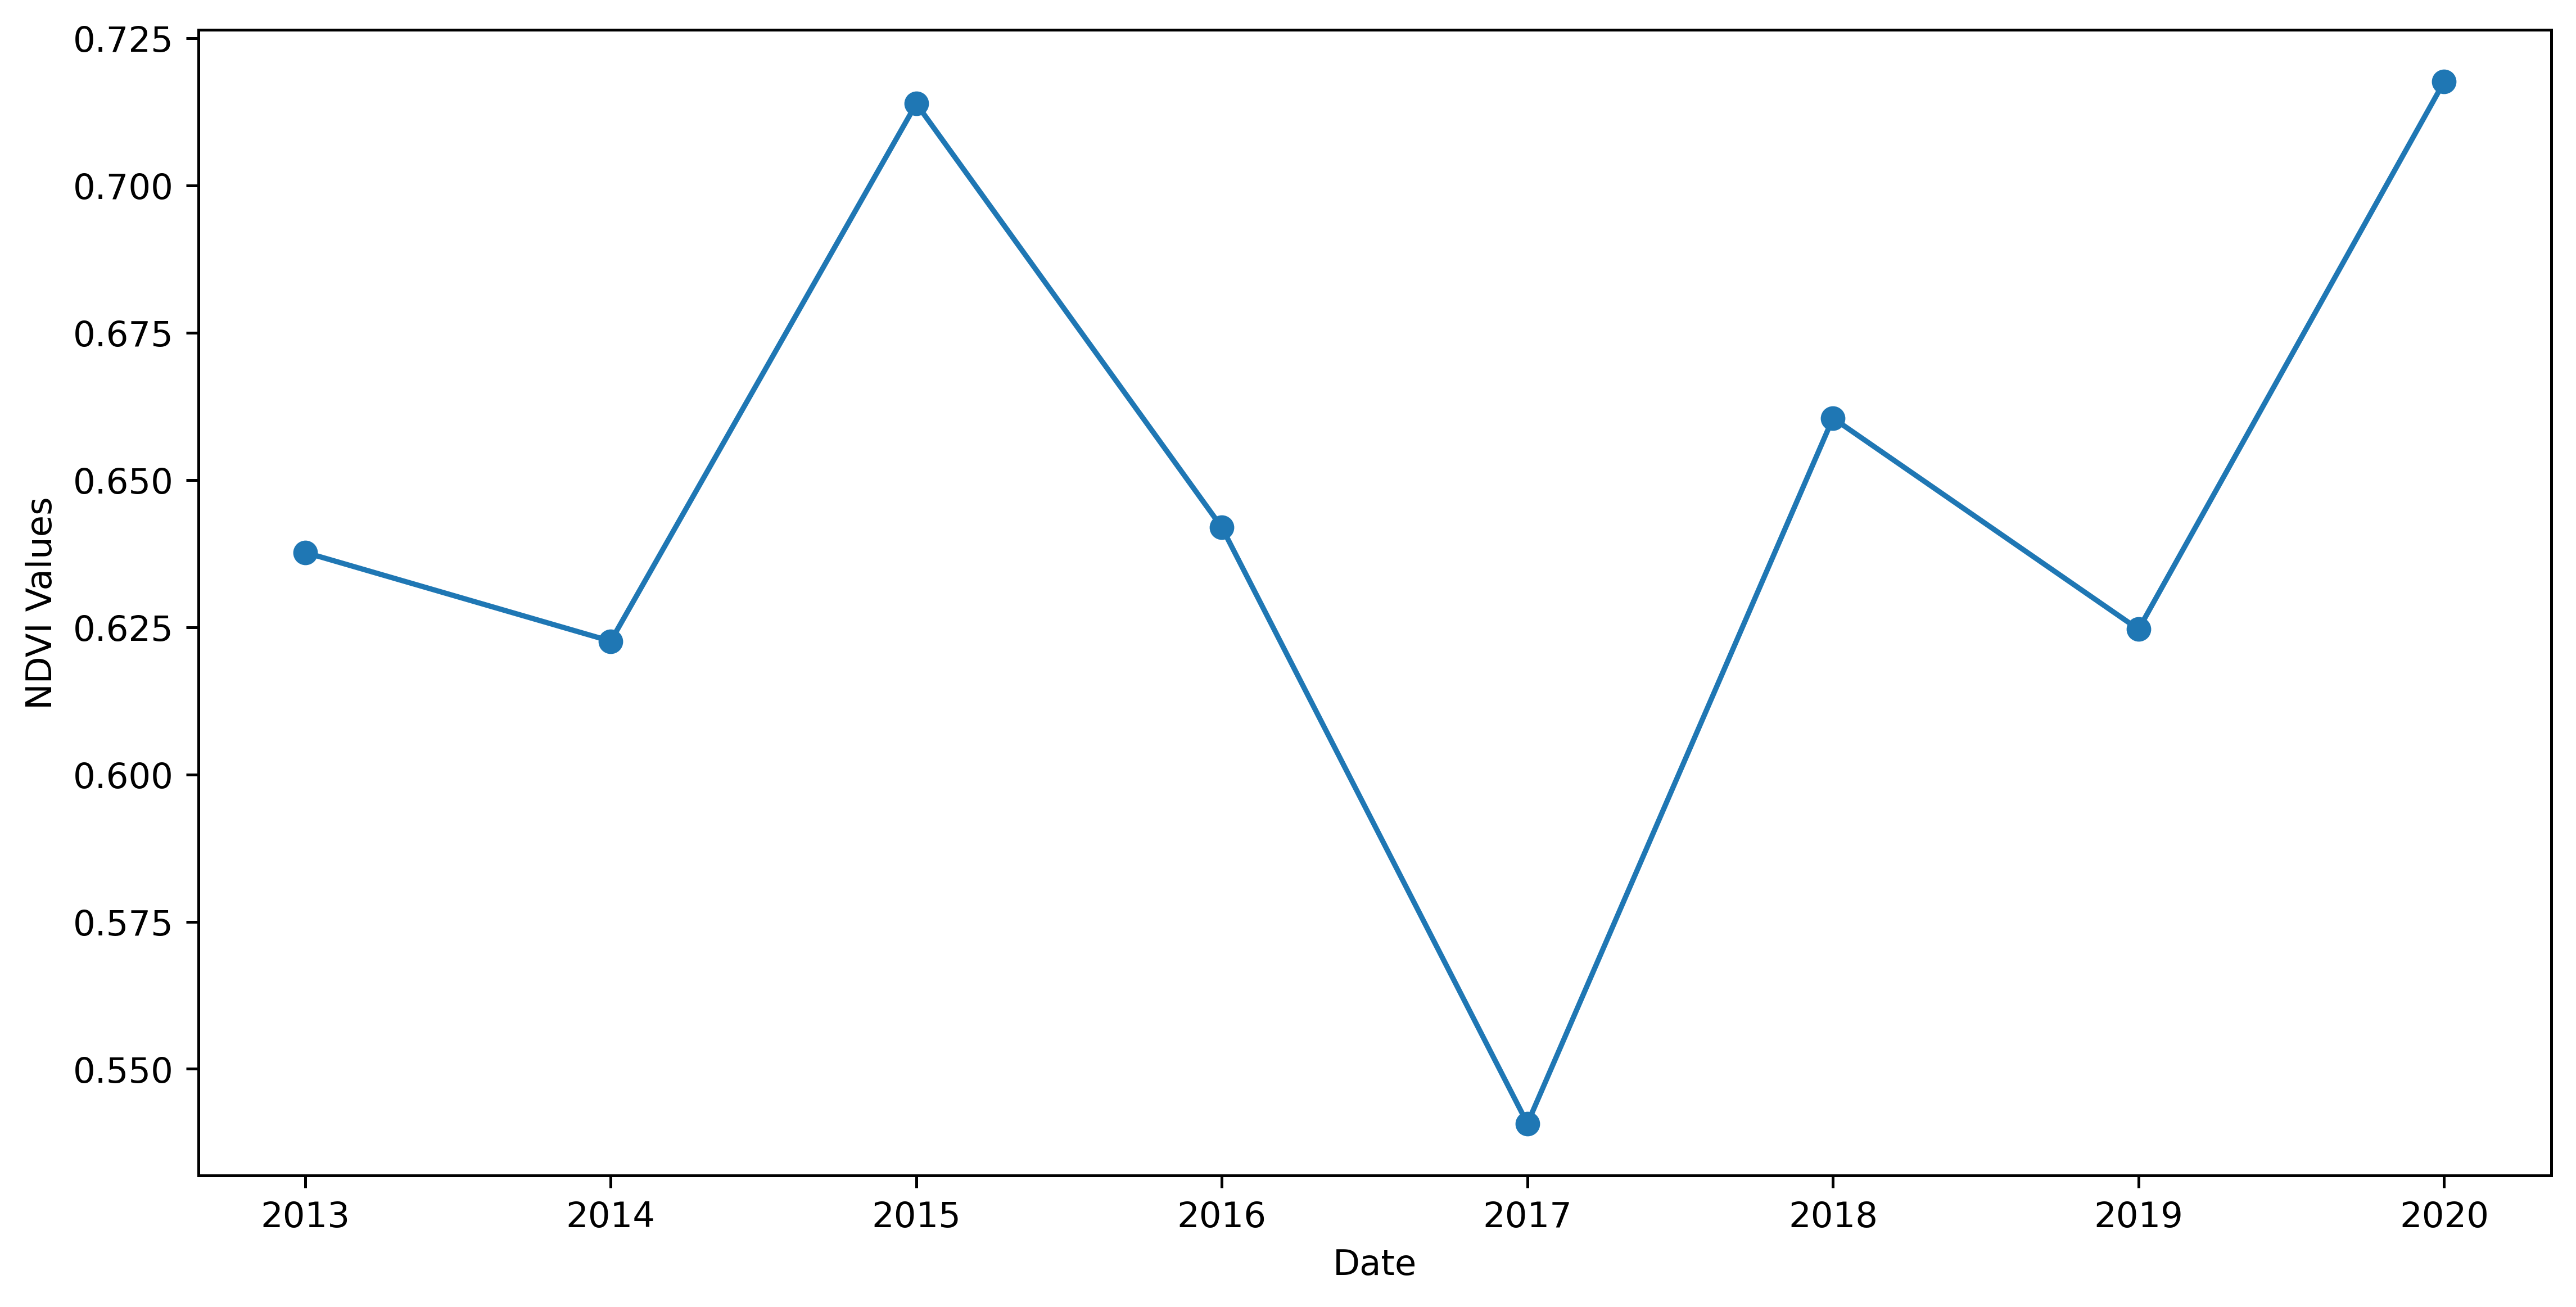

In [28]:
#画图
import matplotlib.pyplot as plt
%matplotlib inline 
# %matplotlib qt 

fig= plt.figure(figsize=(12,6),dpi=450)

x = range(2013,2020+1)

plt.plot(x, areaList, marker='o')
plt.xlabel('Date')
plt.ylabel('NDVI Values')
plt.show()

In [20]:
#定义difference函数，计算两年之间NDVI的差异
#考虑到后续需要重复调用difference函数，给出了六个参数
#cal_VI为计算的植被指数类型如NDVI,year1为起始年,year2为终止年,choice为选择输出影像数据还是数值
#index为之后比较两个年份NDVI差值时设定的阈值,areaList为差值的面积数值
import folium
def difference(cal_VI,year1,year2,choice,index,areaList):
  print(year1,year2)
  yearly_image1 = images.filterDate(str(year1)+"-01-01",str(year1)+"-12-31")
  yearly_image2 = images.filterDate(str(year2)+"-01-01",str(year2)+"-12-31")
  yearly_ndvi_image1 = yearly_image1.map(cal_VI)
  yearly_ndvi_image2 = yearly_image2.map(cal_VI)
  yearly_mean_ndvi_extent1 = yearly_ndvi_image1.mean()
  yearly_mean_ndvi_extent2 = yearly_ndvi_image2.mean()
  difference_image = yearly_mean_ndvi_extent2.subtract(yearly_mean_ndvi_extent1)
  difference_image_change=difference_image.gt(index)
  stats = difference_image_change.multiply(ee.Image.pixelArea()).reduceRegion(
      reducer = ee.Reducer.sum(),
      geometry = roi,
      scale = 30
      ).get('nd').getInfo()
  if choice==1:
    return difference_image
  else:
    print(stats)
    areaList.append(stats/1000000)
    return areaList

"  map_evi = folium.Map(location=(-1.5,34.5), zoom_start=9)\n  stats = difference_image.multiply(ee.Image.pixelArea()).reduceRegion(\n    reducer = ee.Reducer.sum(),\n    geometry = roi,\n    scale = 30\n  ).get('nd').getInfo()\n  print(stats)\n  # Add the image layer to the map and display it.\n  map_evi.add_ee_layer(\n      difference_image, {'min': -1, 'max': 1, 'palette': ['FF0000', '00FF00']}, 'ndvi')\n  display(map_evi)"

In [18]:
!apt install proj-bin libproj-dev libgeos-dev
#为解决colab无法安装Basemap函数

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
libgeos-dev set to manually installed.
libproj-dev is already the newest version (4.9.3-2).
libproj-dev set to manually installed.
The following NEW packages will be installed:
  proj-bin
0 upgraded, 1 newly installed, 0 to remove and 37 not upgraded.
Need to get 32.3 kB of archives.
After this operation, 110 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 proj-bin amd64 4.9.3-2 [32.3 kB]
Fetched 32.3 kB in 0s (129 kB/s)
Selecting previously unselected package proj-bin.
(Reading database ... 155225 files and directories currently installed.)
Preparing to unpack .../proj-bin_4.9.3-2_amd64.deb ...
Unpacking proj-bin (4.9.3-2) ...
Setting up proj-bin (4.9.3-2) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


# **Data export**

Export an image to Google Drive

In [14]:
def tasksave(calNDVI):    
  for i in range(2013,2020):
    task = ee.batch.Export.image.toDrive(image=difference(calNDVI,i,i+1,1,0,areaList),
                                         region=roi,
                                         description='changeform'+str(i)+'to'+str(i+1),
                                         folder='ndvichange',
                                         scale=30,
                                         crs='EPSG:4326')
    task.start()
tasksave(calNDVI)

2013 2014
2014 2015
2015 2016
2016 2017
2017 2018
2018 2019
2019 2020


Inspect current exporting status

In [42]:
task.status()

{'attempt': 1,
 'creation_timestamp_ms': 1641636003253,
 'description': 'changeform13to14',
 'destination_uris': ['https://drive.google.com/#folders/1KSJ2AYR1uN8W0hu2Gw-yCQK1A1AqlC13'],
 'id': 'EQNQ4JBSDDVHWTOJ3VU4E4ZC',
 'name': 'projects/earthengine-legacy/operations/EQNQ4JBSDDVHWTOJ3VU4E4ZC',
 'start_timestamp_ms': 1641636051398,
 'state': 'COMPLETED',
 'task_type': 'EXPORT_IMAGE',
 'update_timestamp_ms': 1641636060915}

In [21]:
areaList1=[]
areaList2=[]
for i in range(2013,2020):
  difference(calNDVI,i,i+1,0,0.1,areaList1)
  difference(calNDVI,i,i+1,0,0.2,areaList2)
print(areaList1)
print(areaList2)

2013 2014
1416517.5223917644
2013 2014
211798.7767944336
2014 2015
30851199.365376342
2014 2015
399889.5973022461
2015 2016
196824.46450243183
2015 2016
8078.074509564568
2016 2017
668289.266641056
2016 2017
30384.70281982422
2017 2018
58661813.61635126
2017 2018
4177849.3440496684
2018 2019
1710002.0544601148
2018 2019
214908.37047119142
2019 2020
43583545.952353366
2019 2020
1294773.2251639576
[0.014165175223917645, 0.3085119936537634, 0.0019682446450243183, 0.006682892666410561, 0.5866181361635125, 0.01710002054460115, 0.4358354595235337]
[0.002117987767944336, 0.003998895973022461, 8.078074509564569e-05, 0.0003038470281982422, 0.04177849344049668, 0.0021490837047119142, 0.012947732251639577]


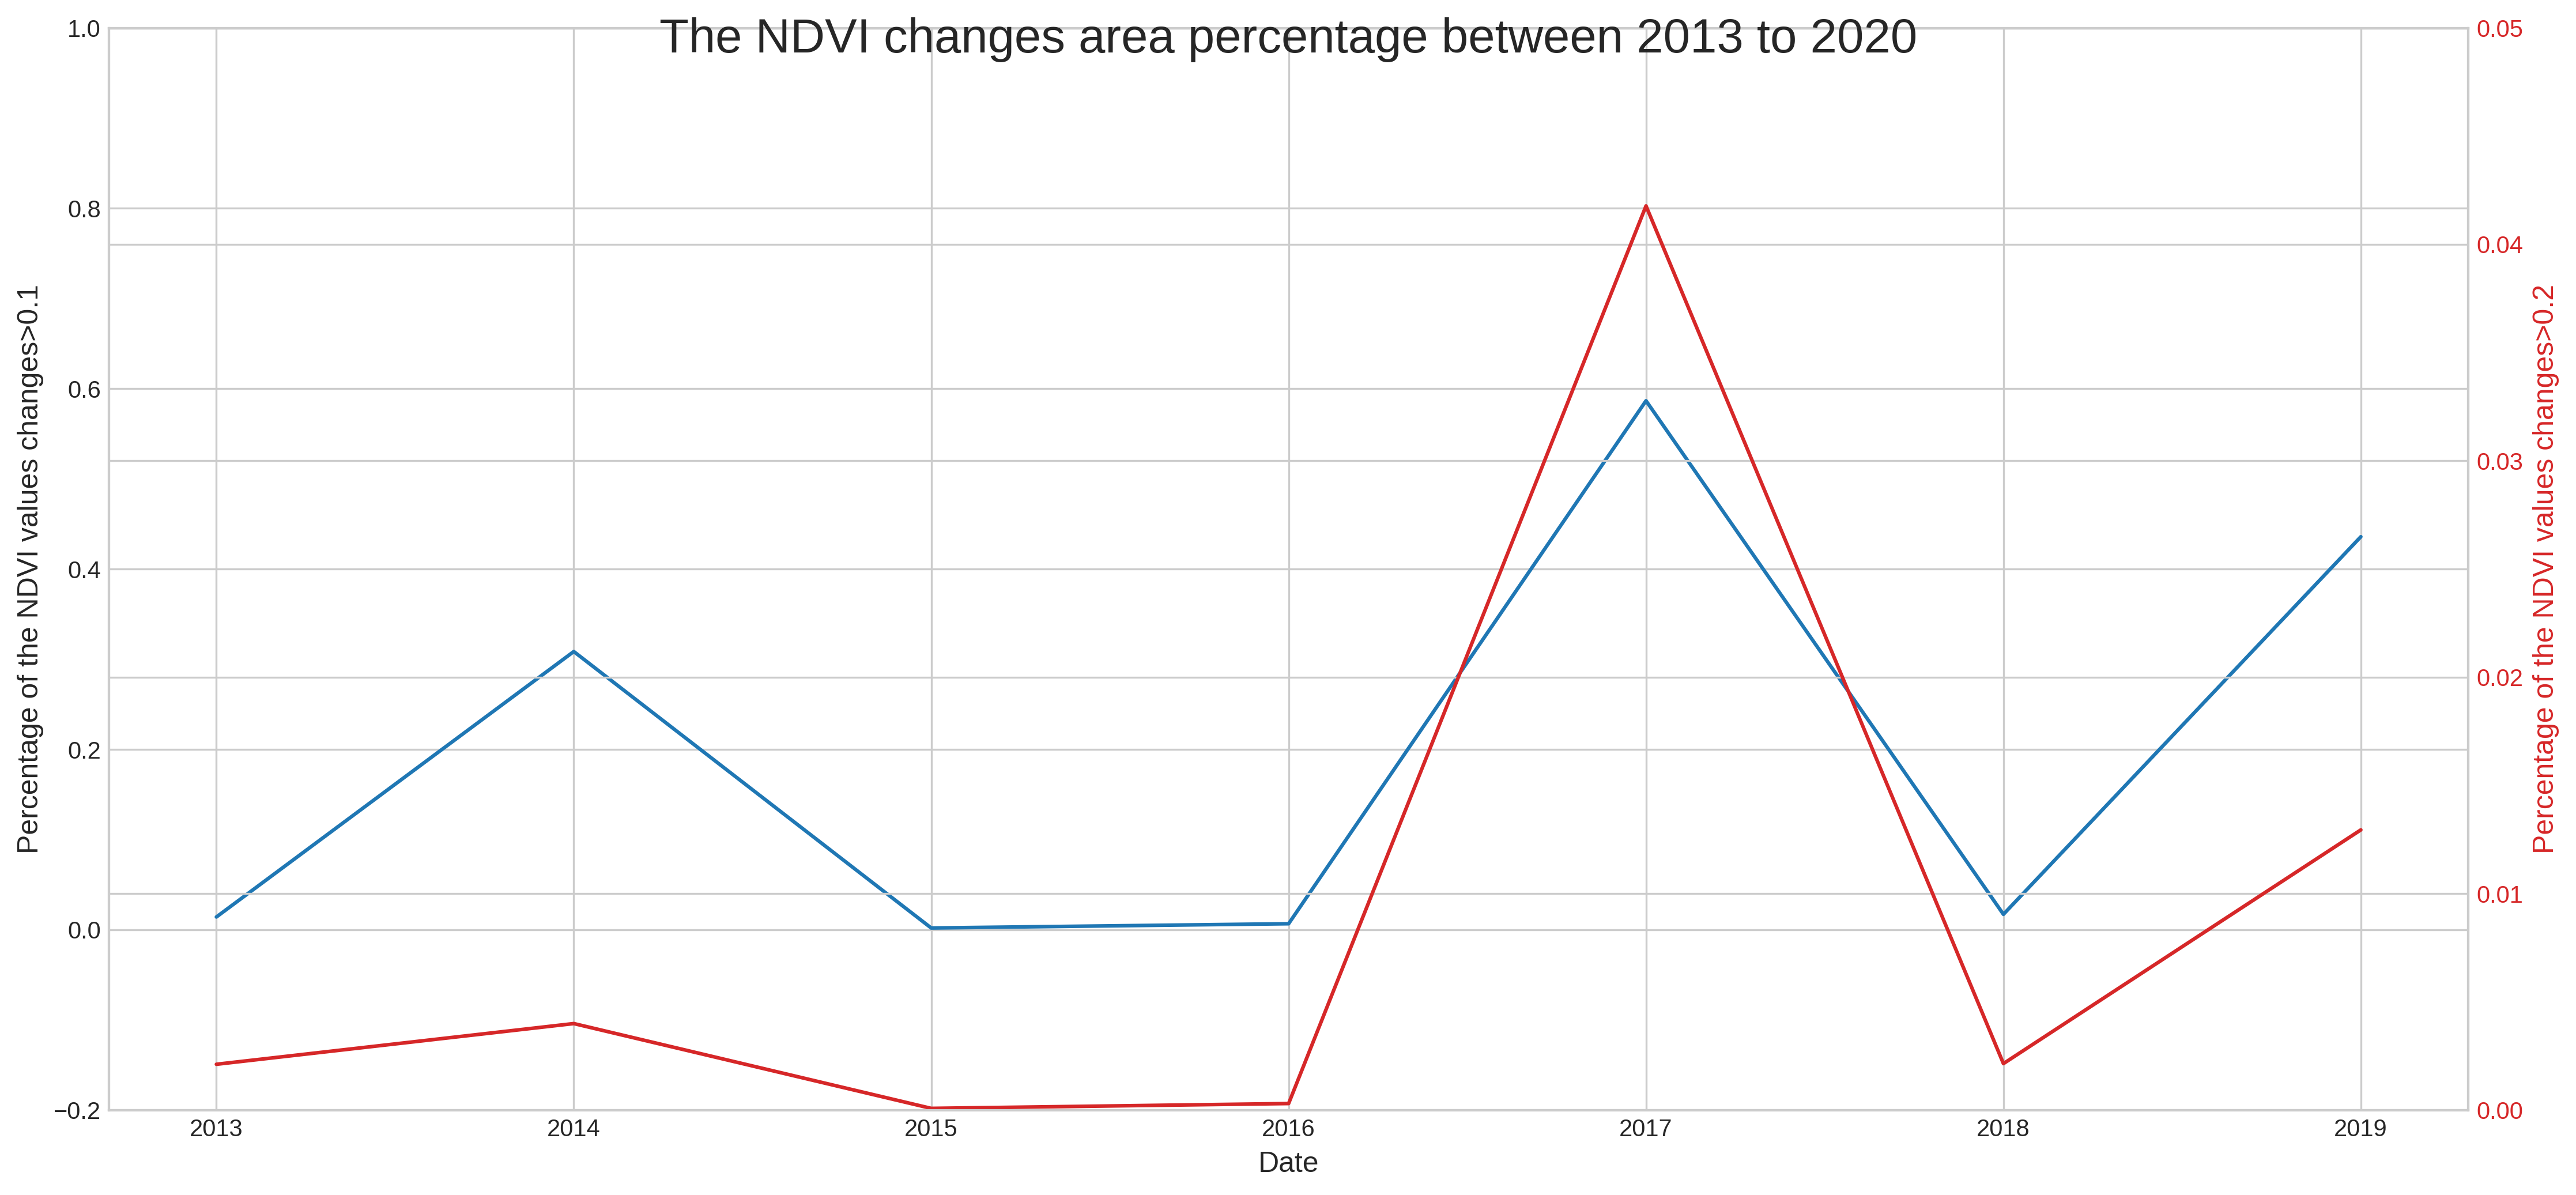

In [32]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
# %matplotlib qt 

fig, ax1 = plt.subplots(1,1,figsize=(15,7), dpi= 300)
x = range(2013,2020)

ax1.plot(x,areaList1)
plt.ylim(-20,100)
plt.style.use('seaborn-whitegrid')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(x, areaList2, color='tab:red')
plt.ylim(0,5)
plt.yticks(fontsize=10)

plt.suptitle("The NDVI changes areas(km^2) between 2013 to 2020",fontsize=20)
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('areas(km^2) of the NDVI values changes>0.1', fontsize=12)
ax2.set_ylabel("areas(km^2) of the NDVI values changes>0.2", color='tab:red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.tight_layout()
plt.show()

In [19]:
from mpl_toolkits.basemap import Basemap
figure, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10), sharey=True, sharex=True,dpi=450) 
# Add a title for the series of plots 
figure.suptitle('Vegetation Index (NDVI) Change Detectionfrom 2013 to 2015', 
                      fontsize=32, fontweight='bold') 
axes[0][0].set_title(u'from 2013 to 07-28',fontsize=20,fontweight='bold')
axes[0][1].set_title(u'from 07-28 to 08-13',fontsize=20,fontweight='bold') 
axes[0][2].set_title(u'from 08-13 to 08-29',fontsize=20,fontweight='bold')
axes[1][0].set_title(u'from 08-29 to 09-14',fontsize=20,fontweight='bold') 
axes[1][1].set_title(u'from 09-14 to 09-30',fontsize=20,fontweight='bold')
axes[0][0].imshow(difference(calNDVI,2013,2014),vmin = -0.2, vmax = 1.0, cmap = 'YlGn',
                              zorder = 5, origin = 'upper', extent= (x0, x1, y0, y1)) 
axes[0][1].imshow(difference(calNDVI,2014,2015),vmin = -0.2, vmax = 1.0, cmap = 'YlGn',
                              zorder = 5, origin = 'upper', extent= (x0, x1, y0, y1)) 
axes[0][2].imshow(difference(calNDVI,2015,2016),vmin = -0.2, vmax = 1.0, cmap = 'YlGn',
                              zorder = 5, origin = 'upper', extent= (x0, x1, y0, y1)) 
axes[1][0].imshow(difference(calNDVI,2016,2017),vmin = -0.2, vmax = 1.0, cmap = 'YlGn',
                              zorder = 5, origin = 'upper', extent= (x0, x1, y0, y1)) 
axes[1][1].imshow(difference(calNDVI,2017,2018),vmin = -0.2, vmax = 1.0, cmap = 'YlGn',
                              zorder = 5, origin = 'upper', extent= (x0, x1, y0, y1)) 
axes[1][2].imshow(difference(calNDVI,2018,2019),vmin = -0.2, vmax = 1.0, cmap = 'YlGn',
                              zorder = 5, origin = 'upper', extent= (x0, x1, y0, y1)) 
# Set up the basemap for each subplot 
m2 =Basemap(projection='cyl',llcrnrlat=-20,urcrnrlat=13,llcrnrlon=-83,urcrnrlon=-34,resolution='l',ellps ='WGS84',ax=axes[0][0]) 
m2.drawcoastlines(zorder = 10), m2.drawcountries(zorder = 10) 
m2.drawmapboundary(fill_color='lightblue'),m2.fillcontinents(color='white') 
m2 =Basemap(projection='cyl',llcrnrlat=-20,urcrnrlat=13,llcrnrlon=-83,urcrnrlon=-34,resolution='l',ellps ='WGS84',ax=axes[0][1]) 
m2.drawcoastlines(zorder = 10), m2.drawcountries(zorder = 10) 
m2.drawmapboundary(fill_color='lightblue'),m2.fillcontinents(color='white')
m2 =Basemap(projection='cyl',llcrnrlat=-20,urcrnrlat=13,llcrnrlon=-83,urcrnrlon=-34,resolution='l',ellps ='WGS84',ax=axes[0][2]) 
m2.drawcoastlines(zorder = 10), m2.drawcountries(zorder = 10) 
m2.drawmapboundary(fill_color='lightblue'),m2.fillcontinents(color='white') 
m2 =Basemap(projection='cyl',llcrnrlat=-20,urcrnrlat=13,llcrnrlon=-83,urcrnrlon=-34,resolution='l',ellps ='WGS84',ax=axes[1][0]) 
m2.drawcoastlines(zorder = 10), m2.drawcountries(zorder = 10) 
m2.drawmapboundary(fill_color='lightblue'),m2.fillcontinents(color='white') 
m2 =Basemap(projection='cyl',llcrnrlat=-20,urcrnrlat=13,llcrnrlon=-83,urcrnrlon=-34,resolution='l',ellps ='WGS84',ax=axes[1][1]) 
m2.drawcoastlines(zorder = 10), m2.drawcountries(zorder = 10) 
m2.drawmapboundary(fill_color='lightblue'),m2.fillcontinents(color='white') 

ModuleNotFoundError: ignored